<br>

<h1 style="text-align:center;">Task 4: Dataset Preparation</h1>



<br>

# Description

---

In Task 5, you will train a deep learning model to detect root pixels. To prepare for this, you need to organize and preprocess your dataset as demonstrated in the Week 2 self-study materials. This involves arranging the dataset files into a specific directory structure and generating image patches (Figure 4.1).

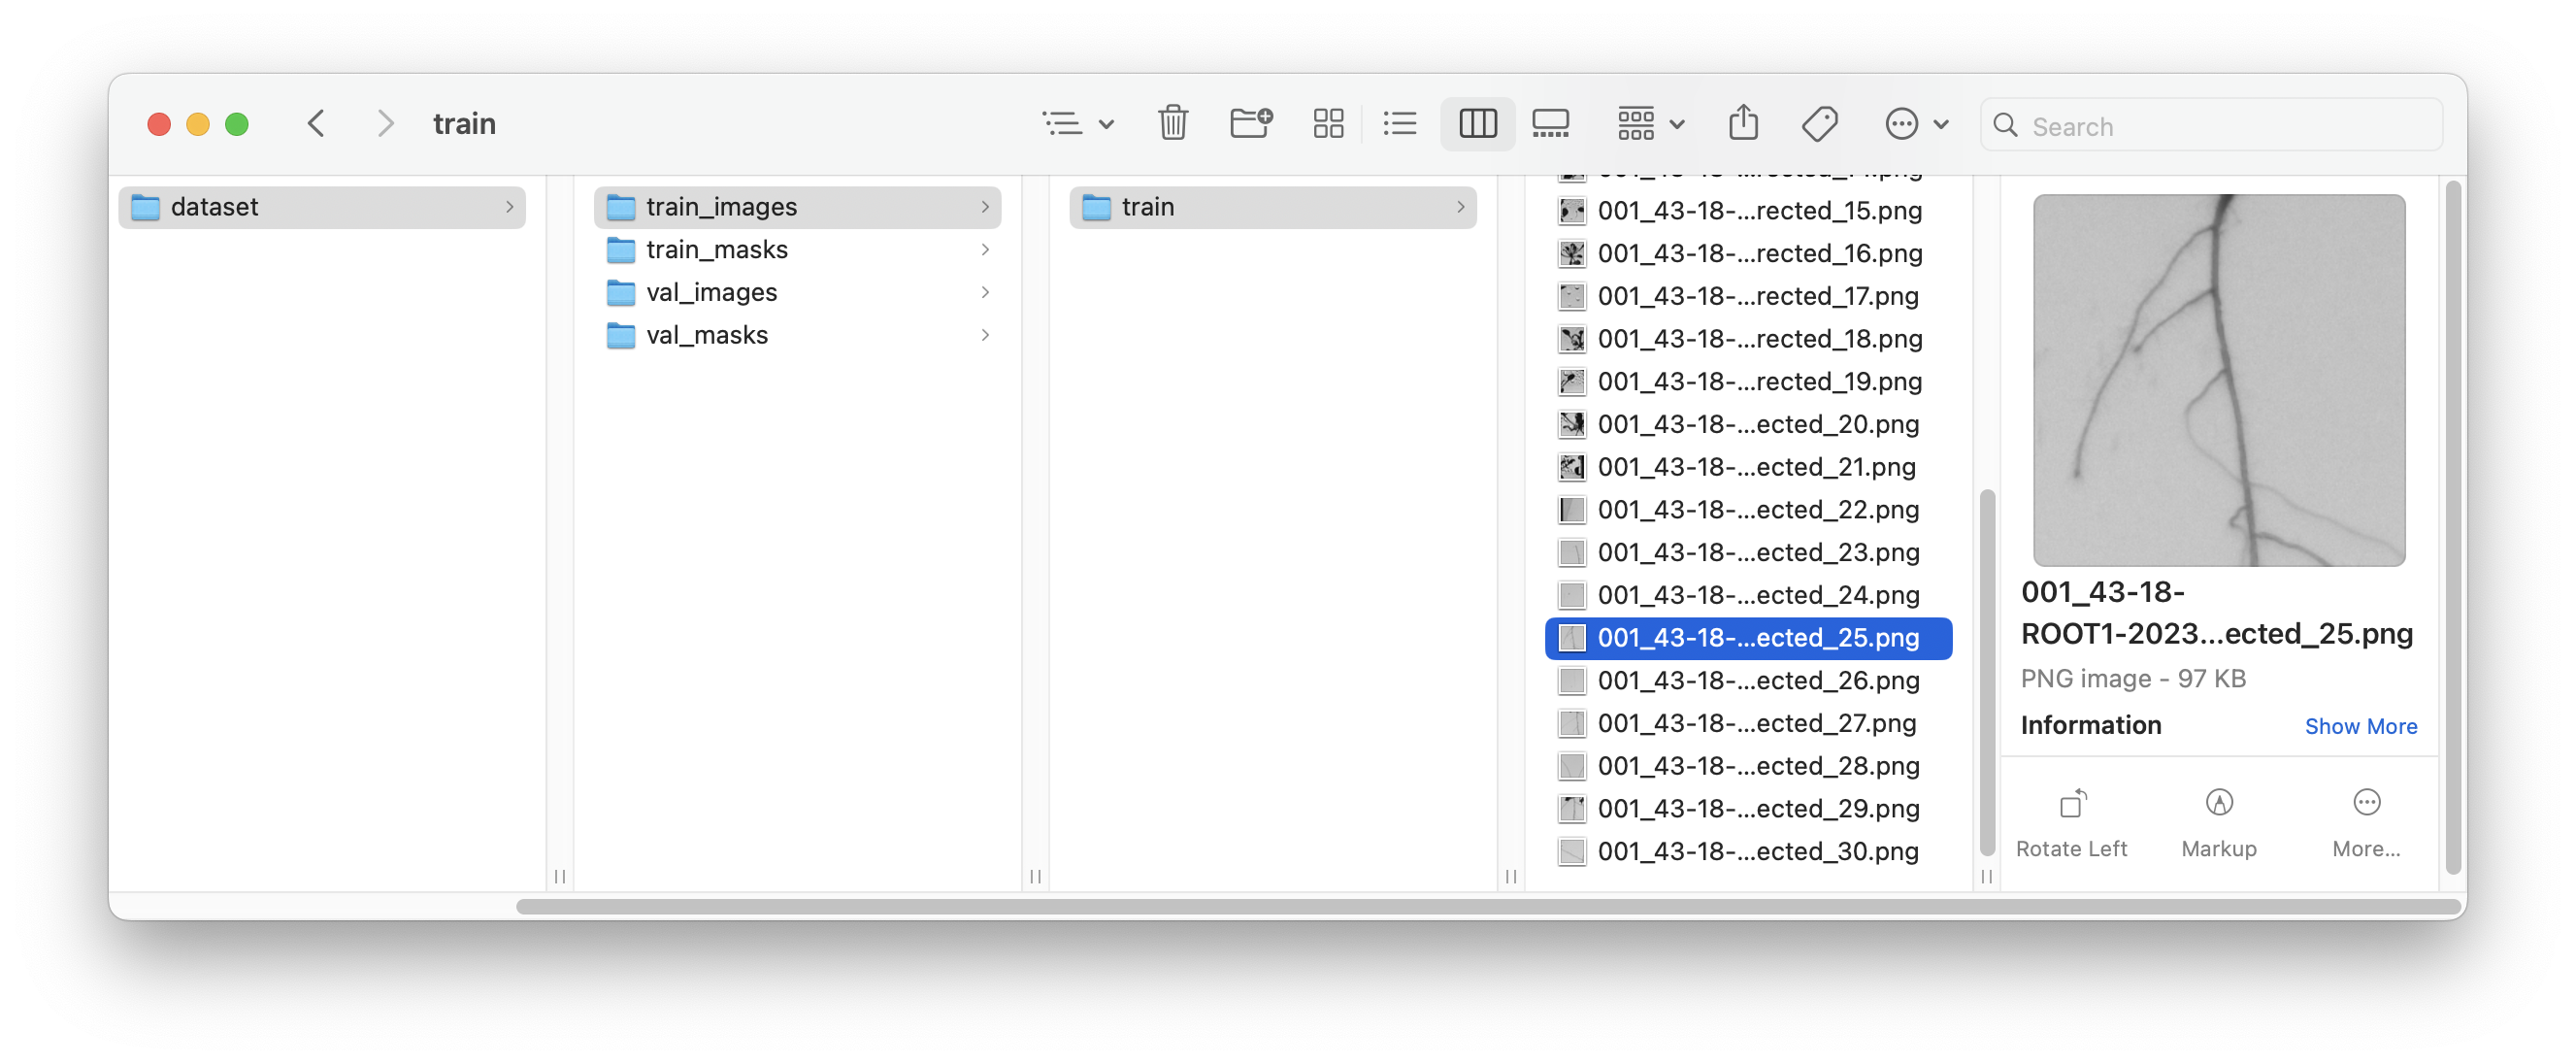


<br>

# Initial Setup

---

In [1]:
# Import the libraries
import os
import glob
import tqdm
import platform
import numpy as np
import pandas as pd
import shutil
from PIL import Image
import cv2
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from patchify import patchify

<br>

## Data Paths

---

In this section, we specified the base path for the dataset, collected image and mask paths for the Y2B_23 and Y2B_24 datasets, removed images without corresponding masks, and reported the counts. We then combined all image and mask paths, defined a function to get matching mask paths, and split the dataset into training and validation sets based on filename prefixes, reporting the final counts for each set.



In [2]:
# Specify the base path
base = "./dataset raw"

In [3]:
# Image/Mask paths in Y2B_23

# Image paths
image_paths_23 = []
for i_folder in glob.glob(f"{base}/Y2B_23/images/*"):   
    for i_image in glob.glob(f"{i_folder}/*.png"):                    
        image_paths_23.append(i_image)                                

# Mask paths
mask_paths_23 = []
for image_path in image_paths_23:                                        
    base_name = os.path.basename(image_path).replace('.png', '')        
    root_mask_path = os.path.join(f"{base}/Y2B_23/masks", 
                                 f"{base_name}_root_mask.tif")          
    if os.path.exists(root_mask_path):                                   
        mask_paths_23.append(root_mask_path)

# Remove images that don't have corresponding masks
image_paths_23 = [
    img_path for img_path in image_paths_23                              
    if os.path.exists(os.path.join(f"{base}/Y2B_23/masks",
    f"{os.path.basename(img_path).replace('.png', '')}_root_mask.tif"))  
]

# Report
print(f"Found {len(image_paths_23)} images in Y2B_23")
print(f"Found {len(mask_paths_23)} masks in Y2B_23")

Found 115 images in Y2B_23
Found 115 masks in Y2B_23


In [4]:
# Image paths
image_paths_24 = glob.glob(f"{base}/Y2B_24/images/*.png")

# Mask paths
mask_paths_24 = []
for image_path in image_paths_24:
    base_name = os.path.basename(image_path).replace('.png', '')      
    name_parts = base_name.split('_')
    person_name = name_parts[1]                                     
    root_mask_path = os.path.join(f"{base}/Y2B_24/masks",      
                                 person_name,
                                 f"{base_name}_root_mask.tif")
    if os.path.exists(root_mask_path):                            
        mask_paths_24.append(root_mask_path)

# Remove images that don't have corresponding masks
image_paths_24 = [
    img_path for img_path in image_paths_24 
    if os.path.exists(os.path.join(
        f"{base}/Y2B_24/masks",
        os.path.basename(img_path).split('_')[1],  # Get person name
        f"{os.path.basename(img_path).replace('.png', '')}_root_mask.tif"
    ))]

# Report
print(f"Found {len(image_paths_24)} images in Y2B_24")
print(f"Found {len(mask_paths_24)} masks in Y2B_24")

Found 269 images in Y2B_24
Found 269 masks in Y2B_24


In [5]:
# Combine all image/mask paths
image_paths = image_paths_23 + image_paths_24
mask_paths = mask_paths_23 + mask_paths_24

# Report
print(f"Found {len(image_paths)} images in total")
print(f"Found {len(mask_paths)} masks in total")

Found 384 images in total
Found 384 masks in total


In [6]:
def get_matching_mask_path(image_path):
    """Find the corresponding mask path for a given image path"""
    
    if 'Y2B_23' in image_path:
        # For Y2B_23 dataset
        base_name = os.path.basename(image_path).replace('.png', '')
        mask_path = os.path.join(
            f"{base}/Y2B_23/masks",  
            f"{base_name}_root_mask.tif"
        )
    else:
        # For Y2B_24 dataset
        base_name = os.path.basename(image_path).replace('.png', '')
        person_name = base_name.split('_')[1]  
        mask_path = os.path.join(
            f"{base}/Y2B_24/masks",
            person_name,
            f"{base_name}_root_mask.tif"
        )
    
    return mask_path if os.path.exists(mask_path) else None

In [7]:
# Split into train/val 
# If the name of the file starts with 'val_', it is a validation image
# If the name of the file starts with 'train_', it is a training image

# Split into train/val 
train_images = image_paths_23.copy()  
val_images = []

# Sort Y2B_24 images based on prefix
for img_path in image_paths_24:
    if os.path.basename(img_path).startswith('val_'):
        val_images.append(img_path)
    else:  # Assumes all other images are training (they should start with 'train_')
        train_images.append(img_path)

# Get corresponding masks
train_masks = [get_matching_mask_path(img) for img in train_images]
val_masks = [get_matching_mask_path(img) for img in val_images]

# Report
print(f"Split {len(train_images)} images into training set")
print(f"Split {len(val_images)} images into validation set")
print(f"Split {len(train_masks)} masks into training set")
print(f"Split {len(val_masks)} masks into validation set")

Split 339 images into training set
Split 45 images into validation set
Split 339 masks into training set
Split 45 masks into validation set


<br>

## Move Images to Target Directories

---

In this section, we created target directories for training and validation images and masks if they didn't already exist. We then determined the operating system to set the appropriate copy command. Using progress bars, we processed and copied training and validation images and their corresponding masks to the target directories, renaming them with sequential numbers. We also handled potential errors and warnings for missing masks.



In [17]:
# Create target directories if they don't exist
target_dirs = [
    'dataset/train_images/train',
    'dataset/train_masks/train',
    'dataset/val_images/val',
    'dataset/val_masks/val'
]

for dir_path in target_dirs:
    os.makedirs(dir_path, exist_ok=True)

In [18]:
# Determine the operating system and set the copy command
is_windows = platform.system() == 'Windows'
copy_cmd = 'copy' if is_windows else 'cp'

In [19]:
# Move training images/masks

# Progress bar for training files
progress_bar = tqdm(total=len(train_images), desc="Processing training files", ncols=100, colour='green')

# Process training images
for idx, img_path in enumerate(train_images):
    
    # Update progress bar
    progress_bar.update(1)
    
    # Find matching mask
    mask_path = get_matching_mask_path(img_path)
    
    if mask_path is None:
        print(f"\nWarning: No matching mask found for {img_path}")
        continue
    
    # Generate new filename with sequential number
    new_name = f"{idx:04d}"
    
    try:
        # Copy and rename image
        img_ext = ".png"
        img_filename = new_name + img_ext
        img_dst_path = os.path.join('dataset/train_images/train', img_filename)
        os_command = f'{copy_cmd} "{img_path}" "{img_dst_path}"'
        os.system(os_command)
        
        # Copy and rename corresponding mask
        mask_ext = ".tif"
        mask_filename = new_name + mask_ext
        mask_dst_path = os.path.join('dataset/train_masks/train', mask_filename)
        os_command = f'{copy_cmd} "{mask_path}" "{mask_dst_path}"'
        os.system(os_command)
        
    except Exception as e:
        print(f"\nError copying files for {img_path}: {str(e)}")

# End progress bar
progress_bar.close()

Processing training files: 100%|██████████████████████████████████| 339/339 [37:42<00:00,  6.67s/it]


In [20]:
# Move validation images/masks

# Progress bar for validation files
progress_bar = tqdm(total=len(val_images), desc="Processing validation files", ncols=100, colour='green')

# Process validation images
start_idx = len(train_images)
for idx, img_path in enumerate(val_images):
    
    # Update progress bar
    progress_bar.update(1)
    
    # Find matching mask
    mask_path = get_matching_mask_path(img_path)
    
    if mask_path is None:
        print(f"\nWarning: No matching mask found for {img_path}")
        continue
    
    new_name = f"{idx + start_idx:04d}"
    
    try:
        # Copy and rename image
        img_ext = ".png"
        img_filename = new_name + img_ext
        img_dst_path = os.path.join('dataset/val_images/val', img_filename)
        os_command = f'{copy_cmd} "{img_path}" "{img_dst_path}"'
        os.system(os_command)
        
        # Copy and rename corresponding mask
        mask_ext = ".tif"
        mask_filename = new_name + mask_ext
        mask_dst_path = os.path.join('dataset/val_masks/val', mask_filename)
        os_command = f'{copy_cmd} "{mask_path}" "{mask_dst_path}"'
        os.system(os_command)
        
    except Exception as e:
        print(f"\nError copying files for {img_path}: {str(e)}")

# End progress bar
progress_bar.close()

Processing validation files: 100%|██████████████████████████████████| 45/45 [05:38<00:00,  7.53s/it]


In [21]:
def load_and_preprocess_image(path):
    """Load and preprocess image"""
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [22]:
# In the visualization section (cells 16-17)
def create_overlay(image, mask):
    """Create overlay of image and root mask"""
    overlay = image.copy()
    mask_rgba = np.zeros((*mask.shape, 4))
    mask_rgba[mask > 0] = [1, 0, 0, 0.3]  # Red for root mask
    overlay = overlay * (1 - mask_rgba[..., 3:4]) + mask_rgba[..., :3] * 255 * mask_rgba[..., 3:4]
    return overlay

In [23]:
def plot_image_and_masks(image_path, mask_path, index):
    """Plot an image with its root mask and overlay"""
    # Load image
    image = load_and_preprocess_image(image_path)
    
    # Load root mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask / 255.0  # Normalize mask to [0,1]
    
    # Create overlay
    overlay = create_overlay(image, mask)
    
    # Create figure
    plt.figure(figsize=(12, 4))
    
    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Original {index}")
    plt.axis('off')
    
    # Plot root mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Root Mask {index}")
    plt.axis('off')
    
    # Plot overlay
    plt.subplot(1, 3, 3)
    plt.imshow(overlay.astype(np.uint8))
    plt.title(f"Overlay {index}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print image name
    print(f"Image {index}: {os.path.basename(image_path)}")

In [24]:
# Get all training images
train_images = glob.glob("./dataset/train_images/train/*.png")

# Select 20 random images
random_indices = random.sample(range(len(train_images)), 20)

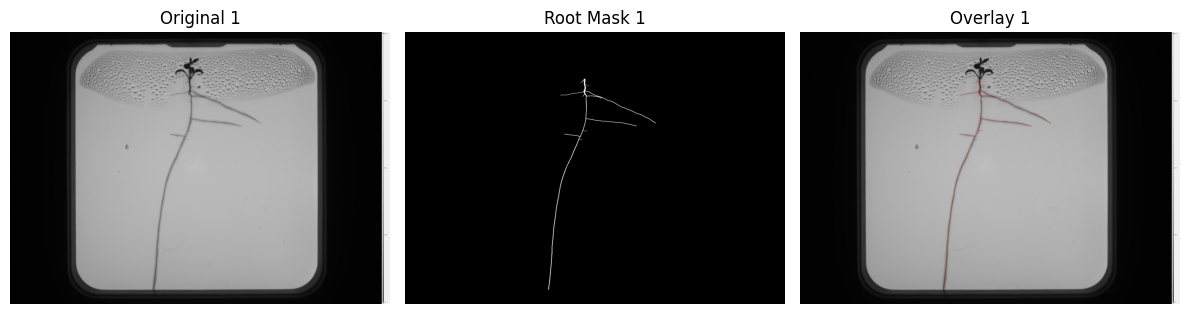

Image 1: 0311.png


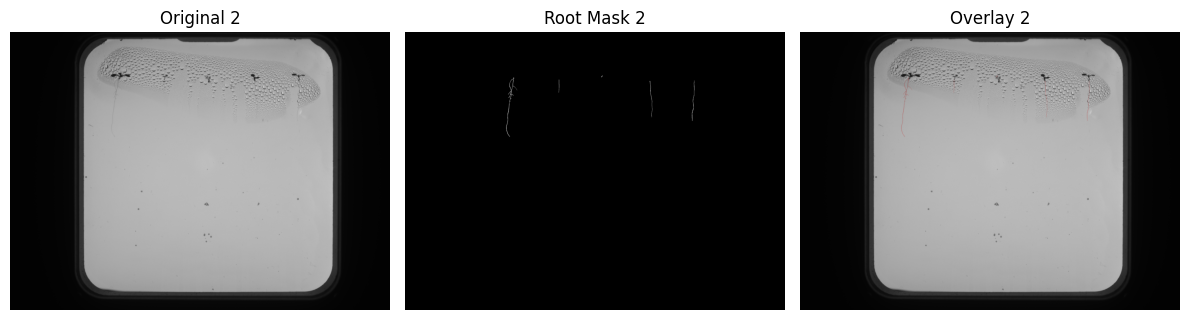

Image 2: 0228.png


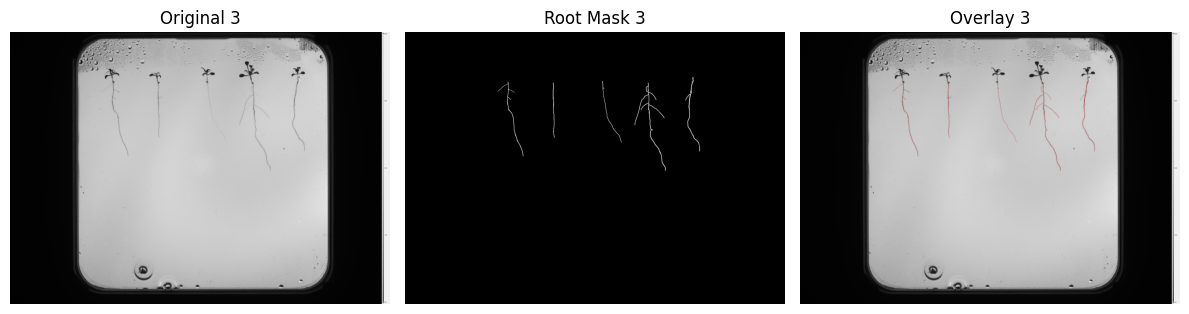

Image 3: 0107.png


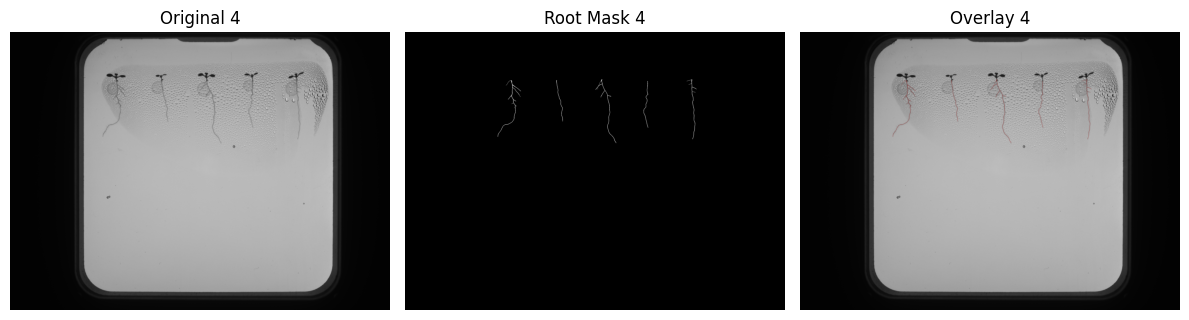

Image 4: 0326.png


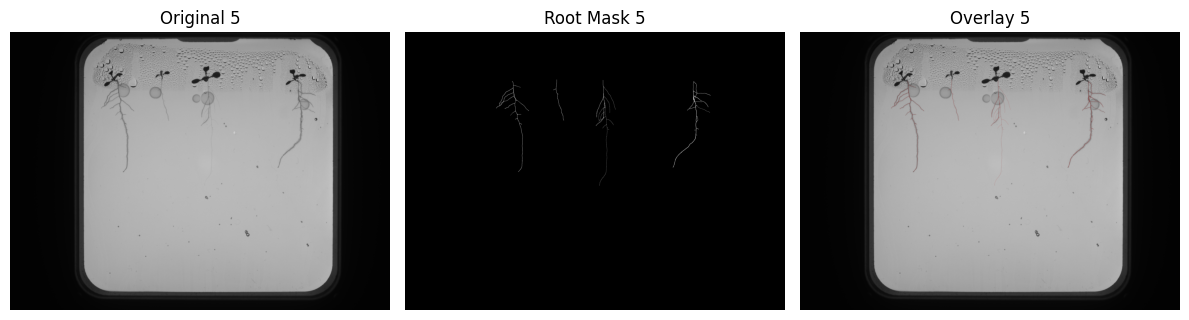

Image 5: 0236.png


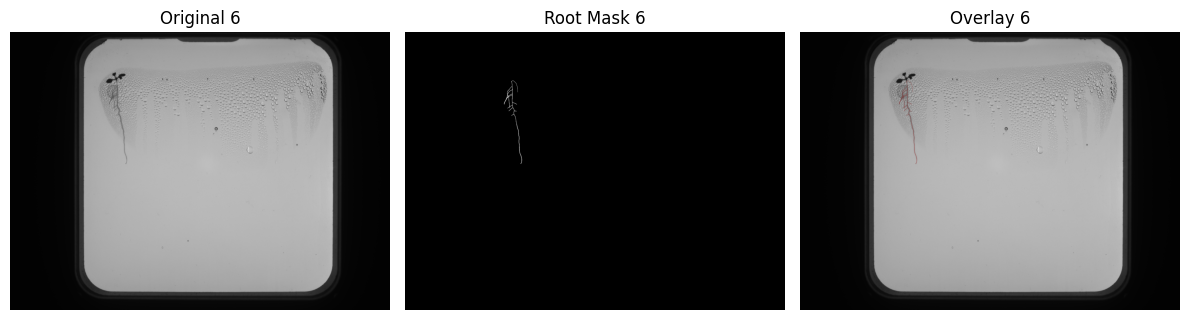

Image 6: 0166.png


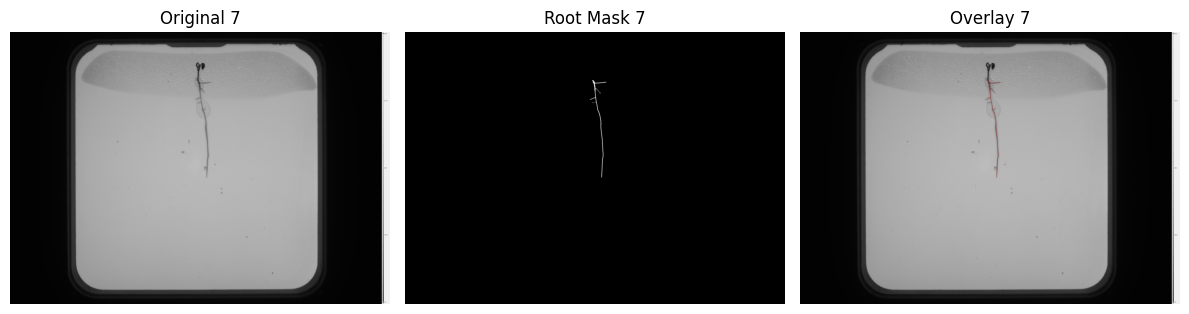

Image 7: 0247.png


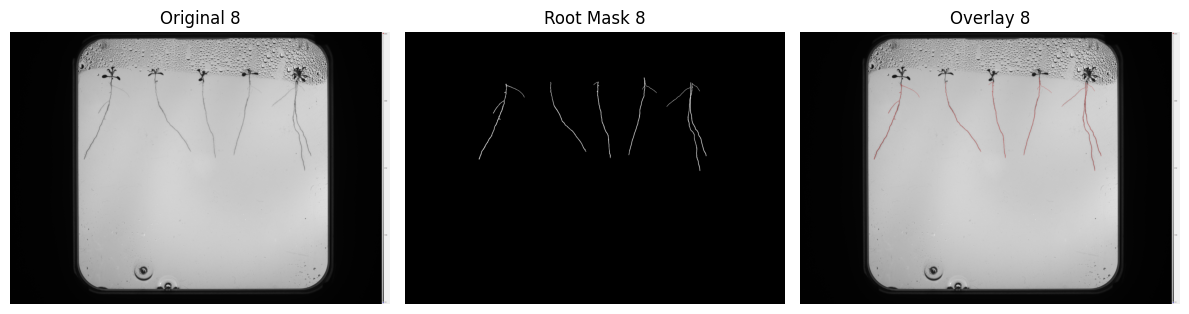

Image 8: 0022.png


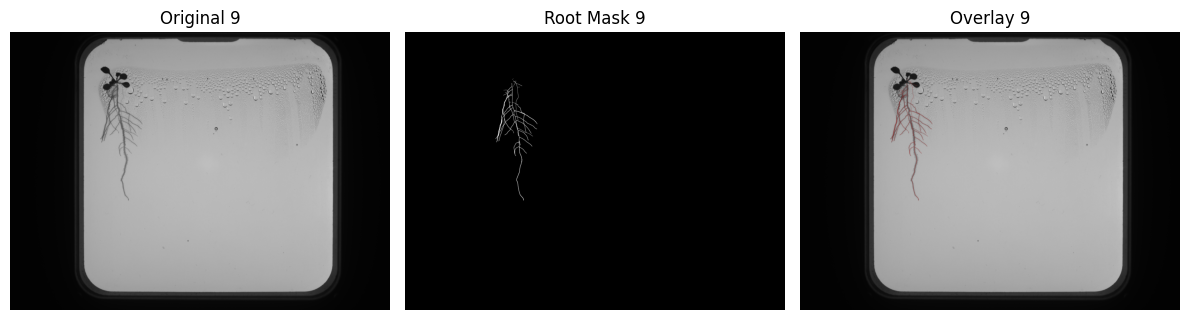

Image 9: 0303.png


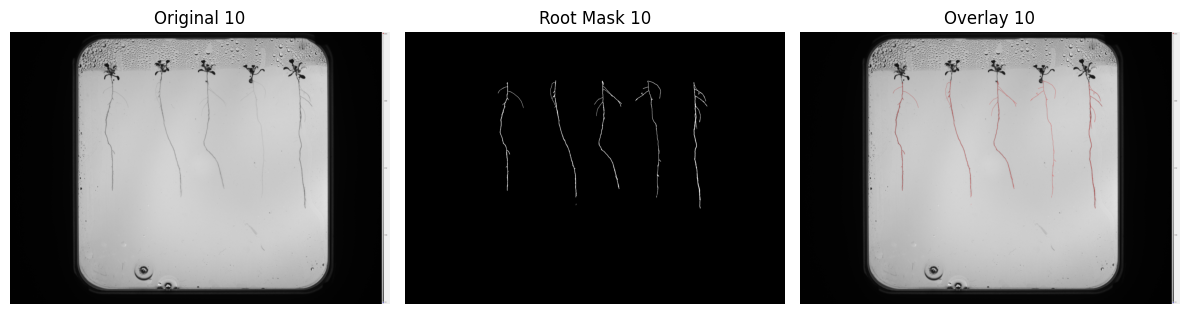

Image 10: 0113.png


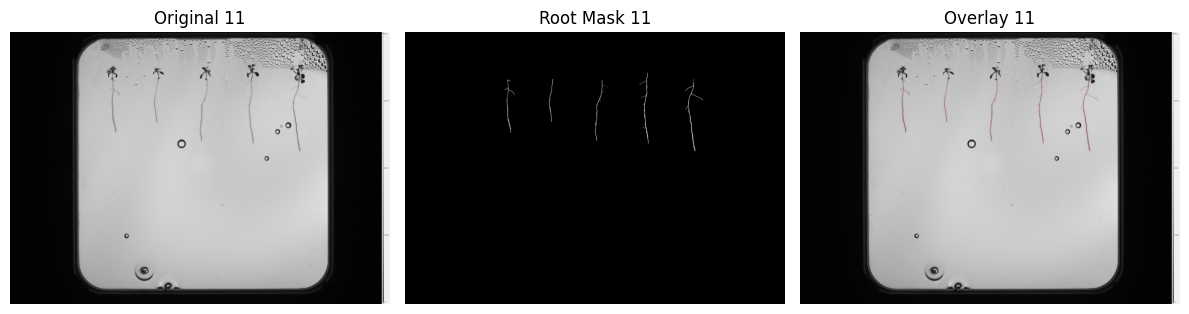

Image 11: 0012.png


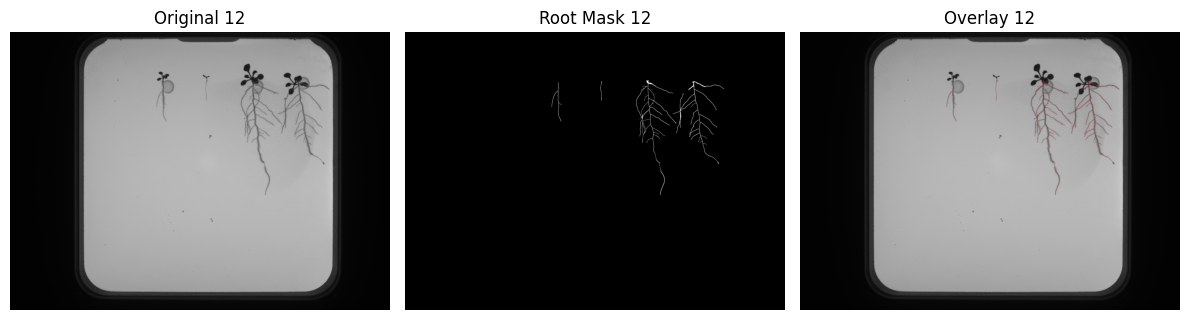

Image 12: 0117.png


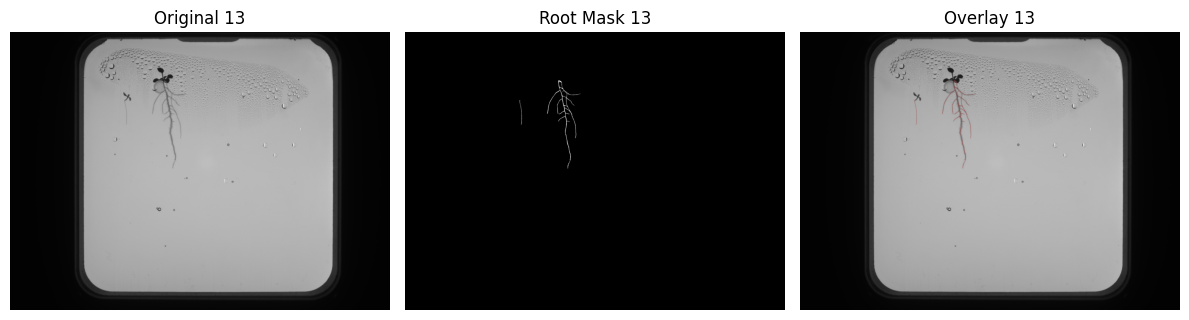

Image 13: 0202.png


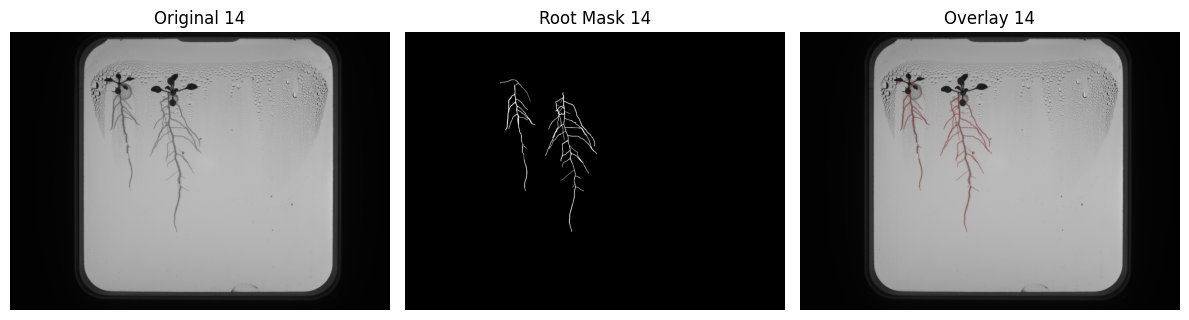

Image 14: 0289.png


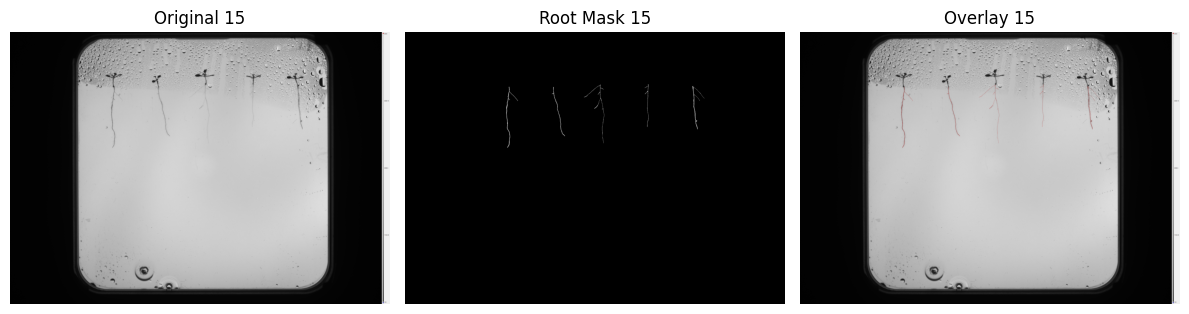

Image 15: 0009.png


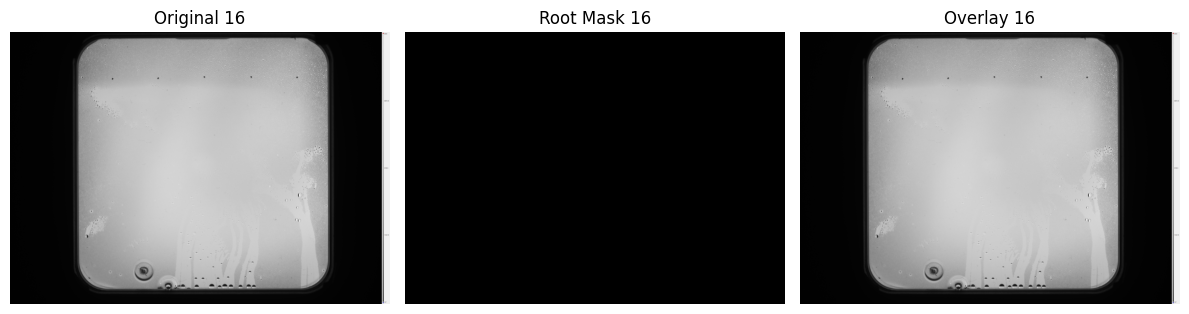

Image 16: 0070.png


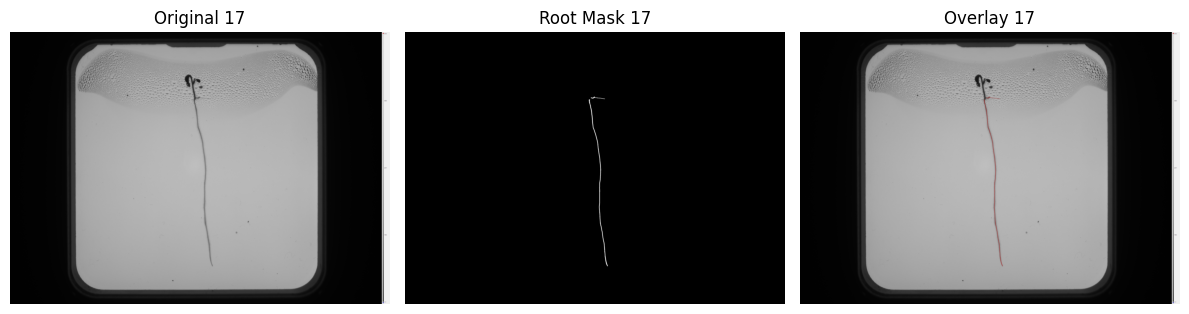

Image 17: 0267.png


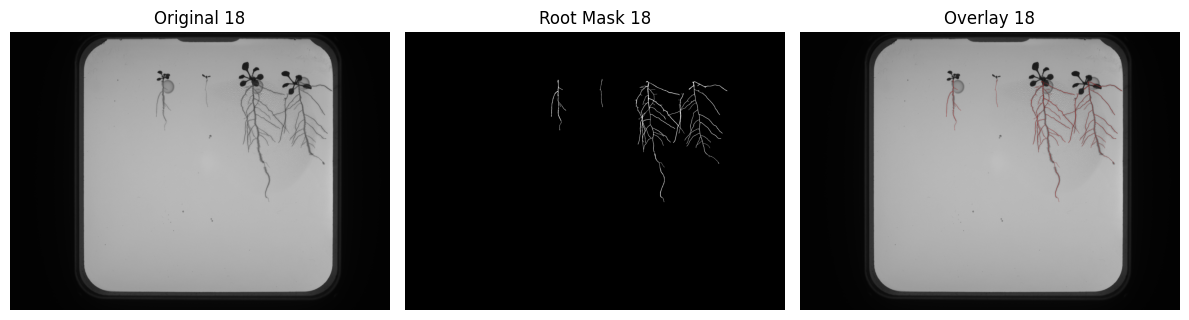

Image 18: 0305.png


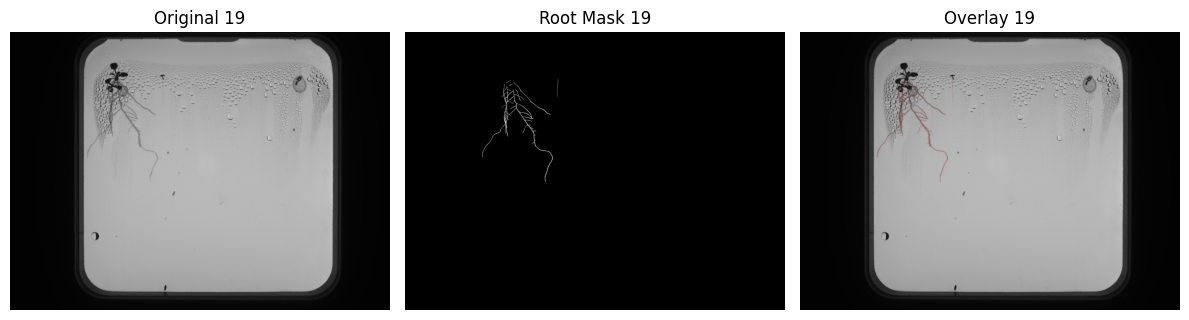

Image 19: 0284.png


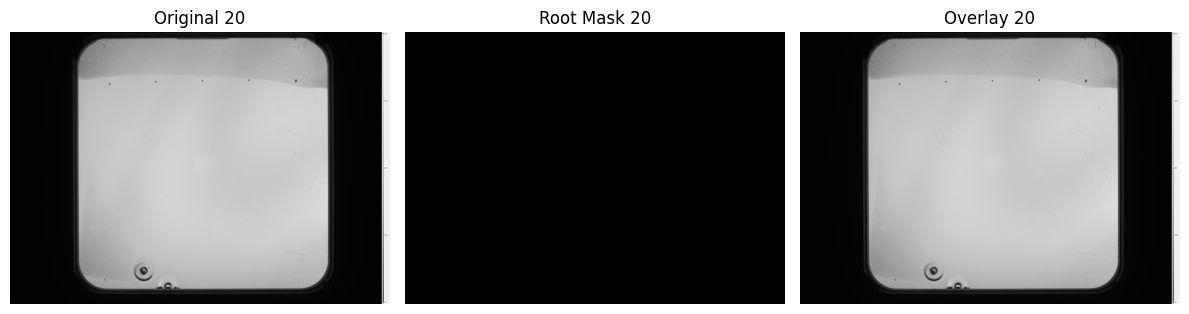

Image 20: 0062.png


In [25]:
for idx, img_idx in enumerate(random_indices):
    # Get image path
    img_path = train_images[img_idx]
    img_name = os.path.basename(img_path).replace(".png", "")
    
    # Get root mask path
    mask_path = f"./dataset/train_masks/train/{img_name}.tif"
    
    # Plot the set
    plot_image_and_masks(img_path, mask_path, idx + 1)

<br>

## Creating Patches 

---

In this section, we visualized a sample image and its mask, calculated the number of patches needed, and drew grid lines on the image to represent the patches. We defined a padder function to add padding to images, ensuring their dimensions are divisible by the patch size. We then set up directories for saving patches and implemented an optimized function to create and save patches using parallel processing. This function processes images and masks, creates patches, saves them, and generates a CSV file with patch statistics. Finally, we called this function to create patches for both training and validation datasets.



In [2]:
patch_dir = 'dataset_patched'
scaling_factor = 1

(-0.5, 2774.5, 2774.5, -0.5)

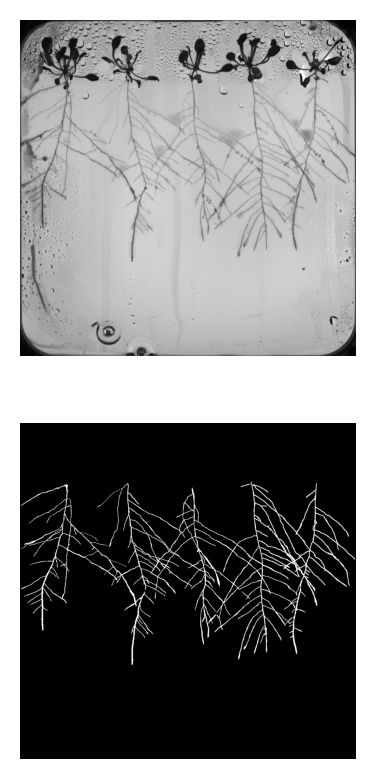

In [6]:
# Load a sample image and mask
image = cv2.imread("./dataset_cropped/train_images/train/0002.png")
mask = cv2.imread("./dataset_cropped/train_masks/train/0002.png", 0)

fig, ax = plt.subplots(2, dpi=200)
ax[0].imshow(image)
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].axis('off')

In [7]:
# Get the image dimensions
height, width = image.shape[:2]

# Report the image dimensions
print(f"Image dimensions: {width}x{height}")

Image dimensions: 2775x2775


Number of patches: 3x3 = 9 total patches
Patch size: 960x960


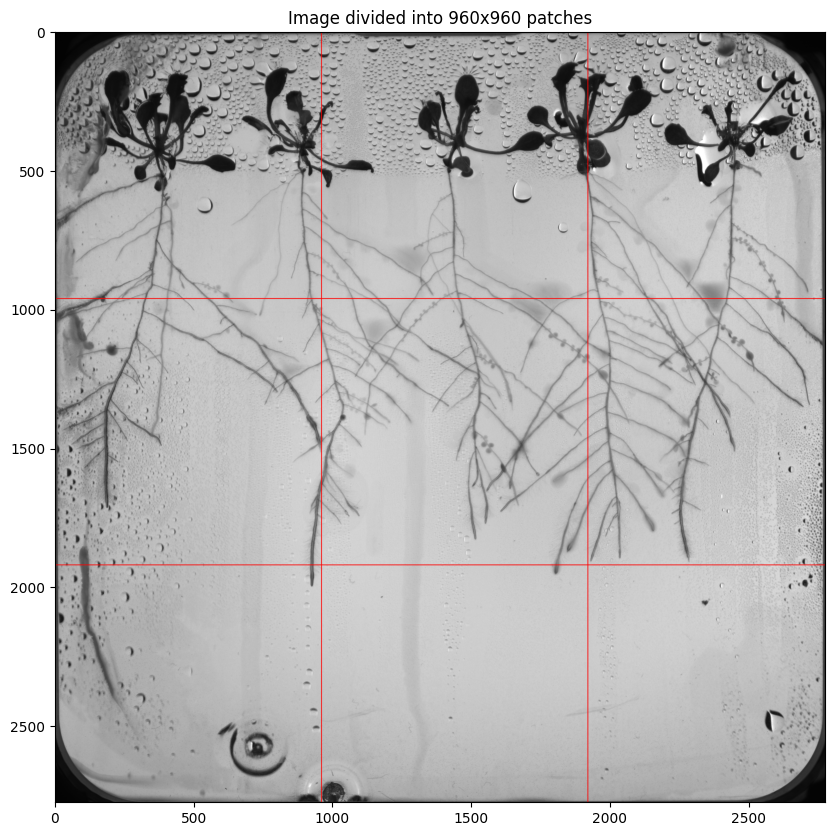

In [8]:
# Patch size
patch_size = 960

# Create a copy of the image to avoid modifying the original
visualization = image.copy()

# Print patch information
num_patches_w = width // patch_size + (1 if width % patch_size else 0)
num_patches_h = height // patch_size + (1 if height % patch_size else 0)
print(f"Number of patches: {num_patches_w}x{num_patches_h} = {num_patches_w * num_patches_h} total patches")
print(f"Patch size: {patch_size}x{patch_size}")

# Draw grid lines
for x in range(0, width, patch_size):
    cv2.line(visualization, (x, 0), (x, height), color=(255, 0, 0), thickness=2)

for y in range(0, height, patch_size):
    cv2.line(visualization, (0, y), (width, y), color=(255, 0, 0), thickness=2)

# Display with proper figure size
plt.figure(figsize=(15, 10))
plt.imshow(visualization)
plt.title(f'Image divided into {patch_size}x{patch_size} patches')
plt.axis('on')
plt.grid(False)
plt.show()

In [18]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [19]:
# Create a new directory for patches
# Folder name will be blood_cell_dataset_patched instead of blood_cell_dataset
import os
patch_dir = f'dataset_patched_{patch_size}'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [20]:
dataset_dir = 'dataset_cropped'

In [21]:
def create_and_save_patches(dataset_type, patch_size, scaling_factor):
    """
    Optimized version of patch creation with parallel processing and reduced I/O operations.
    """
    from concurrent.futures import ThreadPoolExecutor
    import pandas as pd
    import numpy as np
    from functools import partial
    
    def process_single_image(image_path, patch_size, scaling_factor, patch_dir, dataset_type):
        """Process a single image and its mask, returning patch information"""
        # Read image and mask
        image = cv2.imread(image_path)
        if  "cropped" in image_path:
            mask_path = image_path.replace('images', 'masks')
        else:
            mask_path = image_path.replace('images', 'masks').replace('.png', '.png')
        mask = cv2.imread(mask_path, 0)
        
        # Pad both image and mask
        if image.shape[0] % patch_size != 0 or image.shape[1] % patch_size != 0:
            image = padder(image, patch_size)
            mask = padder(mask, patch_size)
        
        # Scale if needed
        if scaling_factor != 1:
            image = cv2.resize(image, (0,0), fx=scaling_factor, fy=scaling_factor)
            mask = cv2.resize(mask, (0,0), fx=scaling_factor, fy=scaling_factor)
        
        # Create patches
        patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        mask_patches = patchify(mask, (patch_size, patch_size), step=patch_size)
        
        # Reshape for easier processing
        patches = patches.reshape(-1, patch_size, patch_size, 3)
        mask_patches = mask_patches.reshape(-1, patch_size, patch_size)
        
        base_filename = os.path.basename(image_path)[:-4]
        records = []
        
        # Process all patches for this image
        for i, (img_patch, mask_patch) in enumerate(zip(patches, mask_patches)):
            patch_filename = f'{base_filename}_{i}.png'
            
            # Save image patch
            image_patch_path = os.path.join(patch_dir, f'{dataset_type}_images', dataset_type, patch_filename)
            cv2.imwrite(image_patch_path, img_patch)
            
            # Save mask patch
            mask_patch_path = os.path.join(patch_dir, f'{dataset_type}_masks', dataset_type, patch_filename)
            cv2.imwrite(mask_patch_path, mask_patch)
            
            # Calculate patch statistics
            has_roots = 1 if np.any(mask_patch > 0) else 0
            root_percentage = (mask_patch > 0).mean() * 100
            
            records.append({
                'filename': patch_filename,
                'has_roots': has_roots,
                'original_image': os.path.basename(image_path),
                'patch_number': i,
                'root_percentage': root_percentage
            })
            
        return records
    
    # Get all image paths
    paths = glob.glob(f'{dataset_dir}/{dataset_type}_images/{dataset_type}/*.png')
    
    # Create output directories if they don't exist
    os.makedirs(os.path.join(patch_dir, f'{dataset_type}_images', dataset_type), exist_ok=True)
    os.makedirs(os.path.join(patch_dir, f'{dataset_type}_masks', dataset_type), exist_ok=True)
    
    # Process images in parallel
    all_records = []
    with ThreadPoolExecutor(max_workers=min(os.cpu_count(), 8)) as executor:
        process_func = partial(process_single_image, 
                             patch_size=patch_size, 
                             scaling_factor=scaling_factor,
                             patch_dir=patch_dir,
                             dataset_type=dataset_type)
        
        # Use tqdm to show progress
        for records in tqdm(executor.map(process_func, paths), 
                          total=len(paths), 
                          desc=f"Processing {dataset_type} images",
                          ncols=100,
                          colour='green'):
            all_records.extend(records)
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(all_records)
    csv_path = os.path.join(patch_dir, f'{dataset_type}_mask_labels.csv')
    df.to_csv(csv_path, index=False)
    
    # Print summary statistics
    print(f"\nDataset: {dataset_type}")
    print(f"Total patches: {len(df)}")
    print(f"Patches with roots: {df['has_roots'].sum()}")
    print(f"Patches without roots: {len(df) - df['has_roots'].sum()}")
    print(f"Average root coverage: {df['root_percentage'].mean():.2f}%")
    print(f"Created CSV file: {csv_path}")
    
    return df

In [22]:
if __name__ == '__main__':

    # Create patches with optimized function
    train_df = create_and_save_patches('train', patch_size, scaling_factor)
    val_df = create_and_save_patches('val', patch_size, scaling_factor)

Processing train images:   0%|                                              | 0/339 [00:00<?, ?it/s]

Processing train images: 100%|████████████████████████████████████| 339/339 [56:27<00:00,  9.99s/it]



Dataset: train
Total patches: 41019
Patches with roots: 8051
Patches without roots: 32968
Average root coverage: 0.53%
Created CSV file: dataset_patched_256/train_mask_labels.csv


Processing val images: 100%|████████████████████████████████████████| 45/45 [06:14<00:00,  8.32s/it]


Dataset: val
Total patches: 5445
Patches with roots: 817
Patches without roots: 4628
Average root coverage: 0.38%
Created CSV file: dataset_patched_256/val_mask_labels.csv
